In [52]:
import xarray as xr
import pandas as pd
import numpy as np
import scipy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import *
import matplotlib.colors as colors
import openpyxl
from netCDF4 import Dataset
import h5netcdf

In [53]:
sourceData='/bettik/amoryc/MARout/GRa/spin2/work/'
variable='TT' ##RF;SF;SHSN3;TT
fileNameM='mon-TT-MARv3.14_ER5-2000-2023.nc' ##change to monthly
dsM= xr.open_dataset(sourceData+fileNameM)['TT']

In [54]:
## Model MAR
sourceDataGrid='/home/amoryc/'
#fileName_grF='NST.2000.01.01.00.GRa_Fedchenko.nc'
fileName_grM='NST.2000.01.01.00.GRa_Mera.nc_ICEmask'
ds_grM= xr.open_dataset(sourceDataGrid+fileName_grM)

In [55]:
#Gra Mera 5km
sourceData='/bettik/amoryc/MARout/GRa/spin2/work/'
variable='TT' ##RF;SF;SHSN3;TT
fileNameM='mon-TT-MARv3.14_ER5-2000-2023.nc' ##change to monthly
dsM= xr.open_dataset(sourceData+fileNameM)['TT'][:,0,:,:] ## montlhy mean

In [56]:
###
#AWS-Mera La: Since November 2013 (AWS inserted on firm rocks – off-glacier)
#Location in WGS84, Lat: 27.735°N; Long: 86.900°E; Elevation: 5352.008 m 
#or UTM Zone 45; Easting: 490137.007 m; Northing: 3067850.613 m on 22/11/2020
###
lon_Naulek=86.89739046
lat_Naulek=27.71772341
elev_Naulek=5360.000
##Find the pixel of MAR corresponding to station
target_lon = lon_Naulek
target_lat = lat_Naulek
lon=ds_grM.LON
lat=ds_grM.LAT

In [57]:
#Step 2: Find the nearest grid point to target_lon,target_lat
# Compute distance to each grid point
dist = np.sqrt((lon - target_lon)**2 + (lat - target_lat)**2)
print(dist)
j, i = np.unravel_index(dist.argmin(), dist.shape)

<xarray.DataArray (y: 116, x: 164)> Size: 76kB
array([[5.279424 , 5.232181 , 5.184988 , ..., 3.5881248, 3.631921 ,
        3.6758704],
       [5.265635 , 5.21825  , 5.1709113, ..., 3.566808 , 3.610866 ,
        3.6551087],
       [5.252194 , 5.2046523, 5.1571703, ..., 3.5459263, 3.590265 ,
        3.6347723],
       ...,
       [6.09539  , 6.0520864, 6.0089116, ..., 4.6114783, 4.647657 ,
        4.6841164],
       [6.1210732, 6.0779243, 6.034923 , ..., 4.644426 , 4.6803765,
        4.7166038],
       [6.1469765, 6.103999 , 6.061146 , ..., 4.6775894, 4.713296 ,
        4.7493043]], shape=(116, 164), dtype=float32)
Coordinates:
  * x        (x) float32 656B -495.0 -490.0 -485.0 -480.0 ... 310.0 315.0 320.0
  * y        (y) float32 464B -195.0 -190.0 -185.0 -180.0 ... 370.0 375.0 380.0


In [58]:
print(j,i)

39 99


In [59]:
#Step 3: Extract data at that location
# For a single time step
#value = dsM['SH'].isel(y=j, x=i)
## If there's a time dimension
dsM_sta=dsM[0:, i, j]
dsM_sta_new2= dsM_sta.rename({'TIME': 'time'})
#units=dsM.units
dsM_sta_new= dsM_sta_new2.where(dsM_sta_new2.values <= 70)
#dsM_sta_new.values


In [60]:
####
## Opening station data
####

In [61]:
path="/bettik/PROJECTS/pr-regional-climate/santolam/glacioclim/donnees_meteo/Naulekfinal2012_24.xlsx"
xl_data=pd.ExcelFile(path)                           
#print(xl_data)  

In [62]:
df= {sheet_name: xl_data.parse(sheet_name)     
       for sheet_name in xl_data.sheet_names}
Data=df['Naulekfinal2012_24']                  
NameVars=['Time','Tairlow','RHlow','Tairhight','RHhight','u','Direction','SWin','SWout','LWincor','LWoutcor','Abl/acc dist sensor surf','tilt metter XAXIS','tilt meter YAXIX']
UnitVars=['data/hour','C','%','C','%','m/s','degrees','W/m2','W/m2','W/m2','W/m2','m','degrees','degrees']

##Define new DataFrame and changing name of columns
dfile= pd.DataFrame(data=Data.loc[4:]) 
df=pd.DataFrame(dfile.values, columns=NameVars) 
### Opening one column + converting into an array
Tairlow_ar=[float(i) for i in df.Tairlow.values]   #Convertit les données en float utilisables 
Tairhight_ar=[float(i) for i in df.Tairhight.values] 

In [63]:
#Pour l'utilisation des données avec xarray, redéfinitions des variables en prenant en compte la fréquence à laquelle les données sont prises ( ici 30 min ) 
def NewTime(
        NameVar,
        Var_ar,
        freq):
    start, end = df.Time.values[0], df.Time.values[-1]
    time = pd.date_range(start, end, freq=freq)
    ds = xr.Dataset({NameVar: ("time",np.asarray(Var_ar)), "time": time})
    return ds 
    
Tlow=NewTime('Tairlow',Tairlow_ar,'30min')
Thight=NewTime('Tairhight',Tairhight_ar,'30min')
T=xr.Dataset()
T['Tair']=((Tlow.Tairlow+Thight.Tairhight)/2)

In [64]:
daily_meanT=T.resample(time='D').mean()                          #Utilisation de la librairie xarray maintenant possible car les données ont une forme bien définie
monthly_meanT=daily_meanT.resample(time='ME').mean()             # chaque variable ici défini est un xarray.Dataset
yearly_meanT=monthly_meanT.resample(time='YE').mean()
#daily_meanTM

In [65]:
#Définition des Saisons, et création d'une fonction qui définit les saisons en fonction des périodes des moussons:
seasons = {
	'MAM': [3, 4, 5],  	
	'JJAS': [6, 7, 8, 9],  
	'ON': [10, 11],    	
	'DJF': [12, 1, 2]  	
}
def seasonsdata(ds, season_name):  #monthly_meanTM.sel(time=monthly_meanTM['time'].dt.month.isin(seasons['MAM'])). Sélectionne dans le dataset les mois correspondants aux saisons définies au dessus

	x = seasons[season_name]
	return ds.sel(time=ds['time'].dt.month.isin(x))


In [66]:
# Get the time coordinates CORRIGER DIFF ENTRE MAR ET STATION
time1 = monthly_meanT['time']# début 2013-11-15 fin 2024-11-28
time2 = dsM_sta_new['time'] # début 2003-01-01T12: fin 2013-12-31T12
start=time1[0] 
end=time2[-1]

In [67]:
ts_sta=monthly_meanT.sel(time=slice(start,end))
ts_MAR=dsM_sta_new.sel(time=slice(start,end))

In [68]:
Tsta_monthly_cycle=monthly_meanT.groupby('time.month').mean()
TMAR_monthly_cycle=dsM_sta_new.groupby('time.month').mean()

In [69]:
Tsta_premon = seasonsdata(monthly_meanT, 'MAM').groupby('time.month').mean()

Tsta_mon = seasonsdata(monthly_meanT, 'JJAS').groupby('time.month').mean()

Tsta_postmon =  seasonsdata(monthly_meanT, 'ON').groupby('time.month').mean()

Tsta_hiver  = seasonsdata(monthly_meanT, 'DJF').groupby('time.month').mean()


In [70]:
#dsM_sta_new
TMAR_premon = seasonsdata(dsM_sta_new, 'MAM').groupby('time.month').mean()

TMAR_mon = seasonsdata(dsM_sta_new, 'JJAS').groupby('time.month').mean()

TMAR_postmon =  seasonsdata(dsM_sta_new, 'ON').groupby('time.month').mean()

TMAR_hiver  = seasonsdata(dsM_sta_new, 'DJF').groupby('time.month').mean()

In [71]:
#T MAR Corrected for [elevation / Hight ? ]
#Evaluer la différence de hauteur entre la station et le niveau 1 de la grille MAR considérée
SH_sta=elev_Naulek
value = ds_grM['SH'].isel(y=j, x=i)
diff=SH_sta-value.values
print(value.values,SH_sta,diff)


TMAR_corrected_premon = TMAR_premon+(-5.9*0.295)

TMAR_corrected_mon = TMAR_mon+(-5.1*0.295)

TMAR_corrected_postmon =  TMAR_postmon+(-5.3*0.295)

TMAR_corrected_hiver  = TMAR_hiver+(-4.7*0.295)


TMAR_monthly_cycle_corrected = TMAR_monthly_cycle+(-5.2*0.295)


5064.1274 5360.0 295.87256


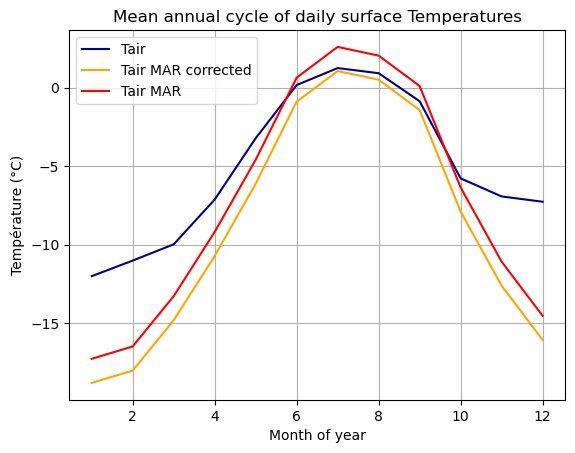

In [72]:
#Monthly cycle

plt.plot(Tsta_monthly_cycle.month,Tsta_monthly_cycle.Tair,
    color='darkblue',linestyle='-',label='Tair')
plt.plot(TMAR_monthly_cycle_corrected.month,TMAR_monthly_cycle_corrected.values,
    color='orange',linestyle='-',label='Tair MAR corrected')
plt.plot(TMAR_monthly_cycle.month,TMAR_monthly_cycle.values,
    color='red',linestyle='-',label='Tair MAR')
plt.legend()
plt.title('Mean annual cycle of daily surface Temperatures')
plt.xlabel('Month of year')
plt.ylabel('Température (°C)')

plt.grid(True)

Text(0, 0.5, 'Negative T Bias (°C)')

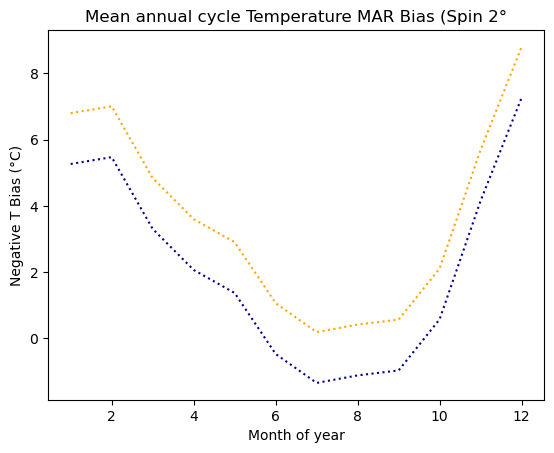

In [73]:
#MAR BIAS over Monthly mean data:
plt.plot(TMAR_monthly_cycle.month, Tsta_monthly_cycle.Tair-TMAR_monthly_cycle.values,
         color='darkblue',linestyle=':',label='Tair;'+'MAR')
plt.plot(TMAR_monthly_cycle_corrected.month, Tsta_monthly_cycle.Tair-TMAR_monthly_cycle_corrected.values,
         color='orange',linestyle=':',label='Tair;'+'MARcorrected')

plt.title('Mean annual cycle Temperature MAR Bias (Spin 2°')
plt.xlabel('Month of year')
plt.ylabel('Negative T Bias (°C)')


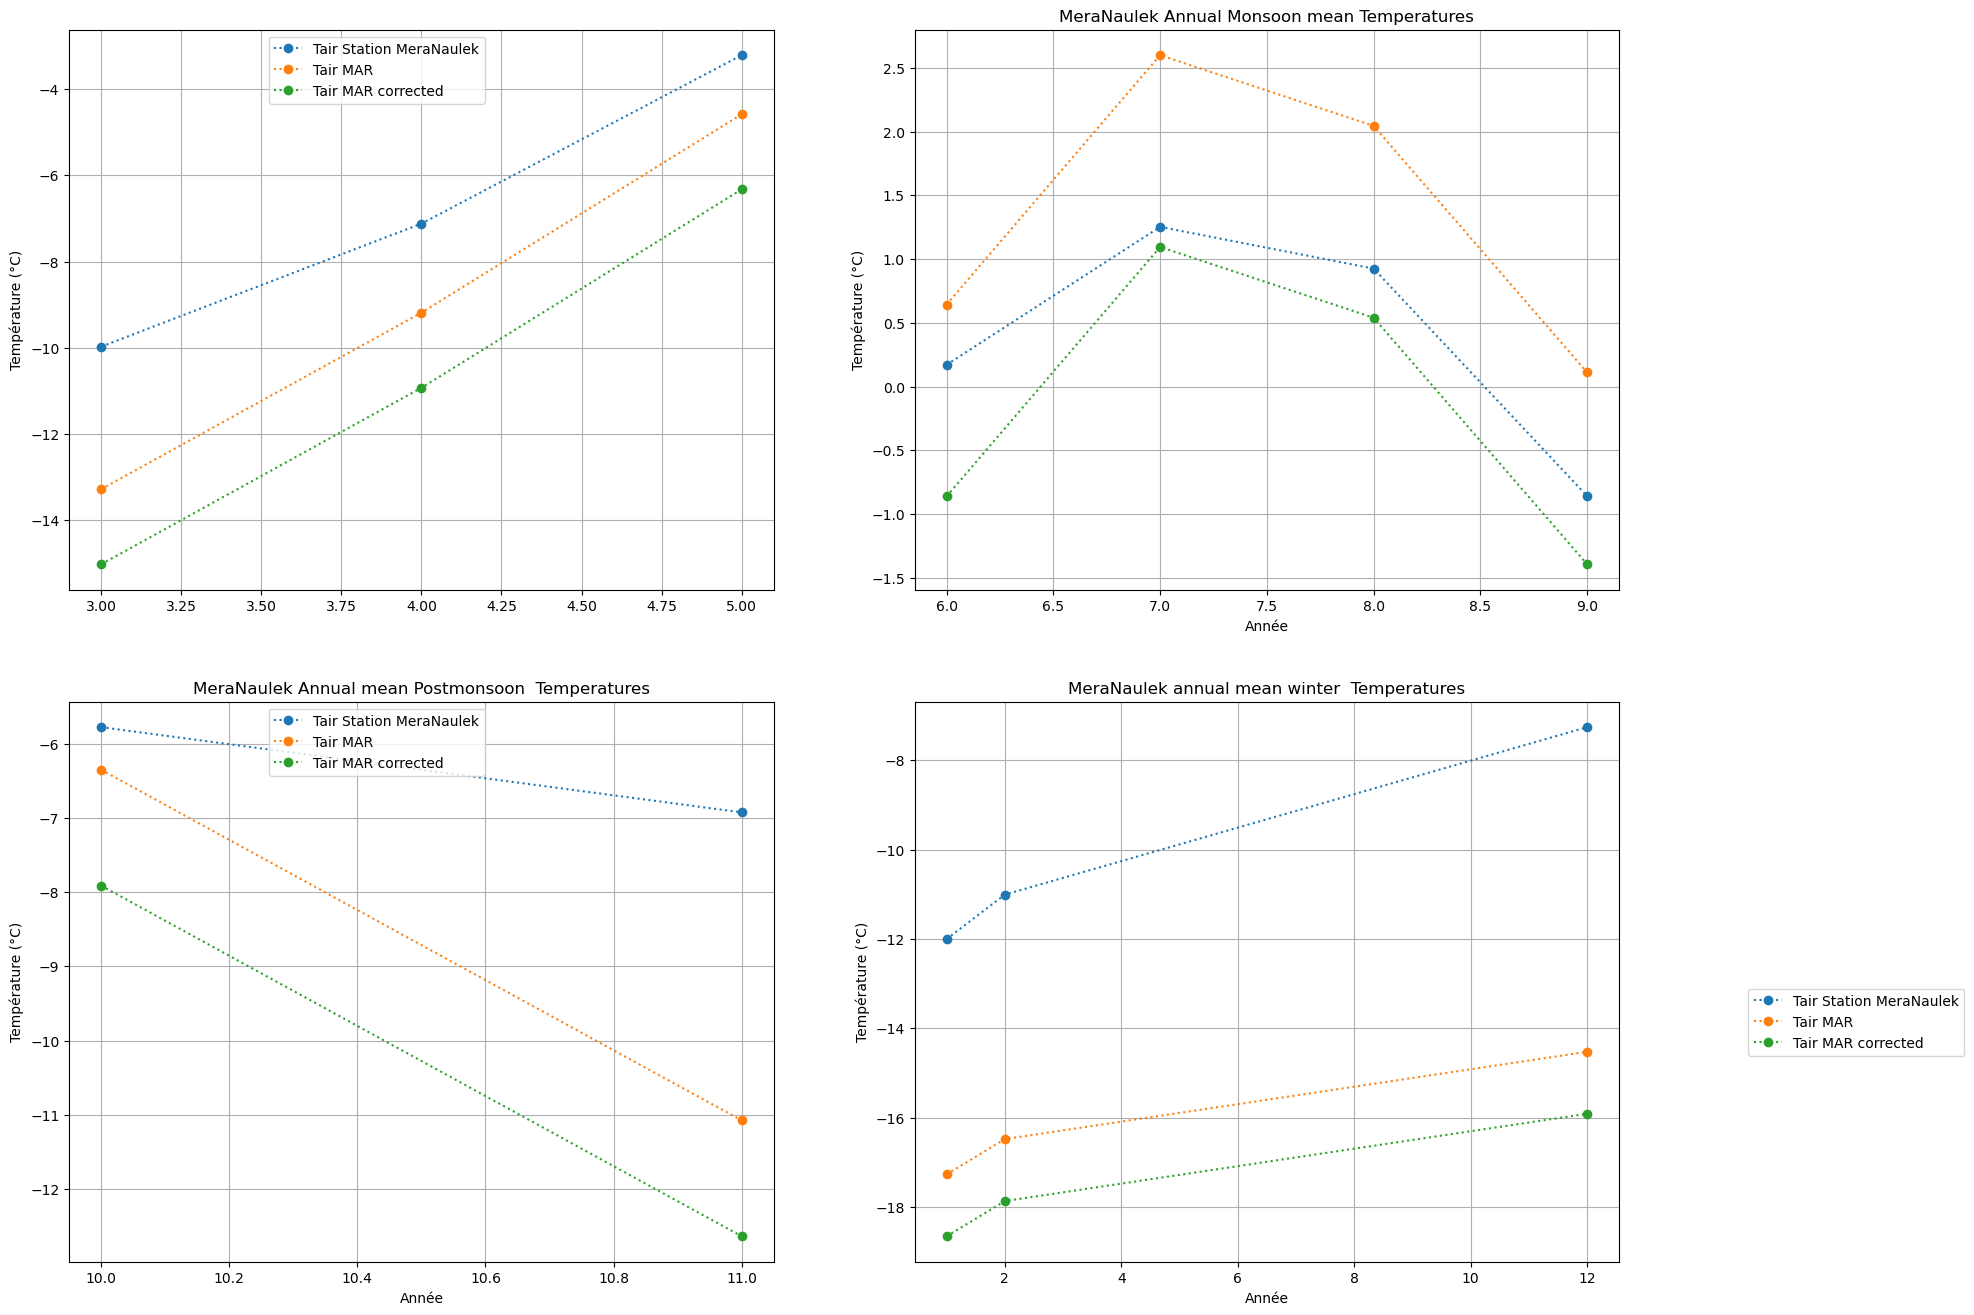

In [75]:
#Ajout incertitudes, 

fig, ((ax1,ax2) , (ax3,ax4)) = plt.subplots(2,2, figsize=(20,16))
ax1.plot(Tsta_premon.month, Tsta_premon['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraNaulek')
ax1.plot(TMAR_premon.month, TMAR_premon.values, linestyle=':', marker= 'o', label='Tair MAR')
ax1.plot(TMAR_corrected_premon.month, TMAR_corrected_premon.values, linestyle=':', marker= 'o', label='Tair MAR corrected')

ax1.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax1.set_title('')
ax1.set_xlabel('')
ax1.set_ylabel('Température (°C)')
ax1.grid()

ax2.plot(Tsta_mon.month, Tsta_mon['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraNaulek')
ax2.plot(TMAR_mon.month, TMAR_mon.values, linestyle=':', marker= 'o', label='Tair')
ax2.plot(TMAR_corrected_mon.month, TMAR_corrected_mon.values, linestyle=':', marker= 'o', label='Tair MAR corrected')

ax2.set_title('MeraNaulek Annual Monsoon mean Temperatures')
ax2.set_xlabel('Année')
ax2.set_ylabel('Température (°C)')
ax2.grid()

ax3.plot(Tsta_postmon.month, Tsta_postmon['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraNaulek')
ax3.plot(TMAR_postmon.month, TMAR_postmon.values, linestyle=':', marker= 'o', label='Tair MAR')
ax3.plot(TMAR_corrected_postmon.month, TMAR_corrected_postmon.values, linestyle=':', marker= 'o', label='Tair MAR corrected')

ax3.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax3.set_title('MeraNaulek Annual mean Postmonsoon  Temperatures')
ax3.set_xlabel('Année')
ax3.set_ylabel('Température (°C)')
ax3.grid()

ax4.plot(Tsta_hiver.month, Tsta_hiver['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraNaulek')
ax4.plot(TMAR_hiver.month, TMAR_hiver.values, linestyle=':', marker= 'o', label='Tair MAR')
ax4.plot(TMAR_corrected_hiver.month, TMAR_corrected_hiver.values, linestyle=':', marker= 'o', label='Tair MAR corrected')

ax4.legend(bbox_to_anchor=(1, 0, 0.5, 0.5)) 
ax4.set_title('MeraNaulek annual mean winter  Temperatures')
ax4.set_xlabel('Année')
ax4.set_ylabel('Température (°C)')
ax4.grid()